In [1]:
# -*- coding: utf-8 -*- Line 2
#----------------------------------------------------------------------------
# Project     : Price Alarm System Enhancement - Alarm3 - Abnormal Price Detection
# Created By  : Eungi Cho
# Created Date: 07/06/22
# Updated Date: 17/06/22
# version ='1.0'
# ---------------------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.impute import KNNImputer

from tqdm import tqdm

warnings.filterwarnings("ignore")
tqdm.pandas()

plt.style.use('default')

In [2]:
import pathlib
df_raw = pd.read_csv('/Users/cho-eungi/Practice/CSV/market_entry_price.csv')
df_raw = df_raw.drop_duplicates()
df_raw.head()

,source_id,country,market_id,product_id,entry_id,currency,final_unit,date,price_min,price_max,price_avg
0,201,South Africa,1487,131,92926374,ZAR,kg,2020-07-20,19.64,21.2,19.956
1,39,India,810,490,41039702,INR,kg,2020-07-06,11.80,12.5,12.200
2,41,India,2188,133,50157058,INR,kg,2020-07-06,50.00,52.7,51.400
3,556,Bangladesh,6581,545,84458922,BDT,kg,2020-07-13,4400.00,4800.0,4600.000
4,150,Turkey,2482,126,58387432,TRY,NaN,2020-07-13,10.00,15.0,11.288


# Data Pre-processsing
Step1: Randomly sampling 30 entries to create 'entry_df'

Step2: Join 'time_df' to each 'entry_df', and make 'df' to reflect the actual frequency of price acquisition

Step3: Use KNN imputer to impute the null value of 'df', and make 'df_imputed'

In [3]:
# entry_lst = np.sort(df_raw['entry_id'].unique())
# np.random.seed(0)
# sample_entry = np.random.choice(entry_lst, 100)
sample_entry = [58650041, 41111413, 58670675, 58655008]

# test_df = sample_entry dataframe - before time_df join
test_df = df_raw.loc[df_raw['entry_id'].isin(sample_entry)].sort_values(
    by = ['source_id', 'market_id', 'entry_id', 'date']).copy()
test_df['date'] = pd.to_datetime(test_df['date'])
test_df

,source_id,country,market_id,product_id,entry_id,currency,final_unit,date,price_min,price_max,price_avg
6964338,282,Taiwan,3930,70,58655008,TWD,kg,2020-01-06,265.0,418.0,364.333333
6774965,282,Taiwan,3930,70,58655008,TWD,kg,2020-01-13,129.0,316.0,245.500000
6866847,282,Taiwan,3930,70,58655008,TWD,kg,2020-02-03,300.5,406.0,384.566667
6959179,282,Taiwan,3930,70,58655008,TWD,kg,2020-02-10,182.7,360.7,297.150000
6865390,282,Taiwan,3930,70,58655008,TWD,kg,2020-02-17,137.0,407.7,309.840000
...,...,...,...,...,...,...,...,...,...,...,...
916565,495,Taiwan,3262,253,58670675,TWD,kg,2022-04-04,15.0,33.0,26.000000
916557,495,Taiwan,3262,253,58670675,TWD,kg,2022-04-11,25.0,35.0,31.900000
834624,495,Taiwan,3262,253,58670675,TWD,kg,2022-04-18,13.0,40.0,26.350000
916564,495,Taiwan,3262,253,58670675,TWD,kg,2022-05-02,26.0,30.0,27.333333


In [4]:
# W-MON date range from 2020 to 2022
# Left Join Test DF and Time DF
empty_df = pd.DataFrame()
for entry in tqdm(sample_entry):
    entry_start = min(df_raw.loc[df_raw['entry_id'] == entry]['date'])
    date_range = pd.date_range(entry_start, '2022-05-31', freq = 'W-MON')
    time_df = pd.DataFrame({'date': date_range})
    
    time_df['entry_id_'] = entry
    entry_df = test_df.loc[test_df['entry_id'] == entry]
    joined_df = pd.merge(time_df, entry_df, left_on = ['date'], right_on = ['date'], how = 'left')
    empty_df = empty_df.append(joined_df)

empty_df = empty_df.drop(['entry_id'], axis = 1)
df = empty_df.copy()
df = df.sort_values(by = ['entry_id_', 'date'])
df.set_index(np.arange(len(df)), inplace=True)
df.head()

100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


,date,entry_id_,source_id,country,market_id,product_id,currency,final_unit,price_min,price_max,price_avg
0,2020-01-06,41111413,352.0,Vietnam,2086.0,14368.0,VND,kg,4750.0,4750.0,4750.0
1,2020-01-13,41111413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-20,41111413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-27,41111413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-03,41111413,352.0,Vietnam,2086.0,14368.0,VND,kg,4750.0,4825.0,4787.5


In [5]:
# Add price_avg imputed column in df using knn_imputer

# Step1: Change 'date' to categorical data and convert to numerical data
df_temp = df.copy()
df_temp['date_category'] = df_temp['date'].astype('category').cat.codes

# Step2: KNNImpute
imputer_ = KNNImputer(n_neighbors = 2)
def knn_impute_price(date_series, price_series):
    before_imputation = pd.DataFrame({'date':date_series, 'price_avg':price_series})
    imputed = imputer_.fit_transform(before_imputation)
    imputed_price_series = imputed[:, 1]
    return imputed_price_series
imputed_price_series = df_temp.groupby(by = 'entry_id_').progress_apply(
                        lambda df : knn_impute_price(df.date_category, df.price_avg)
                      )
imputed_price_series = pd.Series(np.concatenate(imputed_price_series.values), name = 'price_avg_imputed')
df = pd.concat([df, imputed_price_series], axis = 1)
df.head()

100%|██████████████████████████████████████████████████| 4/4 [00:00<00:00, 170.25it/s]


,date,entry_id_,source_id,country,market_id,product_id,currency,final_unit,price_min,price_max,price_avg,price_avg_imputed
0,2020-01-06,41111413,352.0,Vietnam,2086.0,14368.0,VND,kg,4750.0,4750.0,4750.0,4750.00
1,2020-01-13,41111413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4768.75
2,2020-01-20,41111413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4768.75
3,2020-01-27,41111413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4806.25
4,2020-02-03,41111413,352.0,Vietnam,2086.0,14368.0,VND,kg,4750.0,4825.0,4787.5,4787.50


# Explanatory Data Analysis
step1: null count by entry in 'df'

step2: calculate variability by entry in 'df'

step3: plot sample entry in 'df' with the largest variability

number of unique entry_id in df:  4
shape of df:  (493, 12)
number of null price_avg data in each entry: 


100%|█████████████████████████████████████████████████| 4/4 [00:00<00:00, 1691.93it/s]


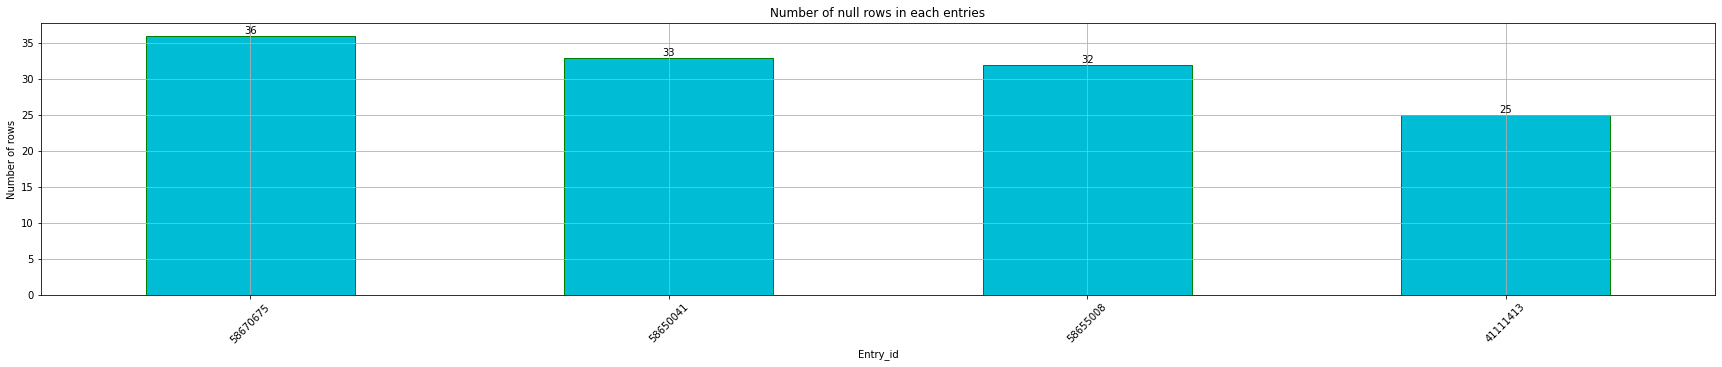

In [6]:
# step1: null count by entry in 'df'
def groupby_count_null(row):
    null_cnt = row.isnull().astype(int).sum()
    return null_cnt

print('number of unique entry_id in df: ', len(df.entry_id_.unique()))
print('shape of df: ', df.shape)
print('number of null price_avg data in each entry: ')

null_cnt_by_entry = df.groupby('entry_id_')['price_avg'].progress_apply(groupby_count_null).sort_values(ascending = False)
# ax = null_cnt_by_entry.plot.hist(
#     figsize=(30, 5), bins = 60, title='Number of null rows in each entries', 
#     fontsize=10, color='#00bcd4', edgecolor='g', linestyle='-', grid=True
# )

ax = null_cnt_by_entry.plot.bar(
    rot = 45, figsize=(30, 5), title='Number of null rows in each entries', 
    fontsize=10, color='#00bcd4', edgecolor='g', linestyle='-', 
    legend=False, grid=True, xlabel='Entry_id', ylabel='Number of rows'
)
ax.bar_label(ax.containers[0])
plt.style.use('default')
plt.show()

In [7]:
# step2: calculate variability by entry in 'df'

def calculate_volatility(row):
    notnull_row = row.values[~np.isnan(row.values)]
    if len(notnull_row) > 0.5 * len(row):
        chg_rate_lst = [(notnull_row[i] - notnull_row[i-1]) * 100 / notnull_row[i-1] for i in range(1, len(notnull_row))]
        volatility = np.mean(chg_rate_lst)
    else:
        volatility = np.nan
    return volatility

volatility_series = df.groupby('entry_id_')['price_avg'].progress_apply(lambda row: calculate_volatility(row))
print(volatility_series.sort_values(ascending=False)[:10])
print('''

Entry_ID with the largest variability:
''')
print(volatility_series[volatility_series.values == volatility_series.max()])

100%|█████████████████████████████████████████████████| 4/4 [00:00<00:00, 1794.55it/s]

entry_id_
41111413    1983.448913
58650041      38.085612
58670675      37.008938
58655008      25.357464
Name: price_avg, dtype: float64


Entry_ID with the largest variability:

entry_id_
41111413    1983.448913
Name: price_avg, dtype: float64


In [8]:
# Pivot_table
df_pivot = df.pivot_table(['price_avg', 'price_avg_imputed']
                          , index = ['entry_id_'], columns = ['date']
                          , dropna = False)
df_pivot.head()

price_avg                                                \
date        2020-01-06 2020-01-13 2020-01-20 2020-01-27   2020-02-03   
entry_id_                                                              
41111413   4750.000000        NaN        NaN        NaN  4787.500000   
58650041           NaN        NaN        NaN        NaN          NaN   
58655008    364.333333      245.5        NaN        NaN   384.566667   
58670675      6.950000        7.0      17.15        NaN    11.000000   

                                                                  ...  \
date      2020-02-10 2020-02-17 2020-02-24 2020-03-02 2020-03-09  ...   
entry_id_                                                         ...   
41111413     4825.00    4825.00   4825.000    4850.00     4775.0  ...   
58650041         NaN        NaN        NaN        NaN        NaN  ...   
58655008      297.15     309.84    335.675     351.95       60.0  ...   
58670675       31.10      25.52     17.780      21.00        NaN  ...   

          price_avg_imputed                                         \
date             2022-03-28   2022-04-04   2022-04-11   2022-04-18   
entry_id_                                                            
41111413        8350.000000  8050.000000  8050.000000  8375.000000   
58650041          82.683334    81.699999    81.466666    80.975000   
58655008         410.649994   315.299988   410.649994   410.649994   
58670675          24.980000    26.000000    31.900000    26.350000   

                                                                            \
date        2022-04-25   2022-05-02   2022-05-09   2022-05-16   2022-05-23   
entry_id_                                                                    
41111413   8375.000000  8400.000000  8375.000000  8375.000000  8375.000000   
58650041     81.254167    81.533333    81.233332    81.383333    81.383333   
58655008    410.649994   410.649994   410.649994   410.649994   410.649994   
58670675     26.841667    27.333333    16.100000    21.716667    21.716667   

                        
date        2022-05-30  
entry_id_               
41111413   8375.000000  
58650041     81.383333  
58655008    410.649994  
58670675     21.716667  

[4 rows x 252 columns]

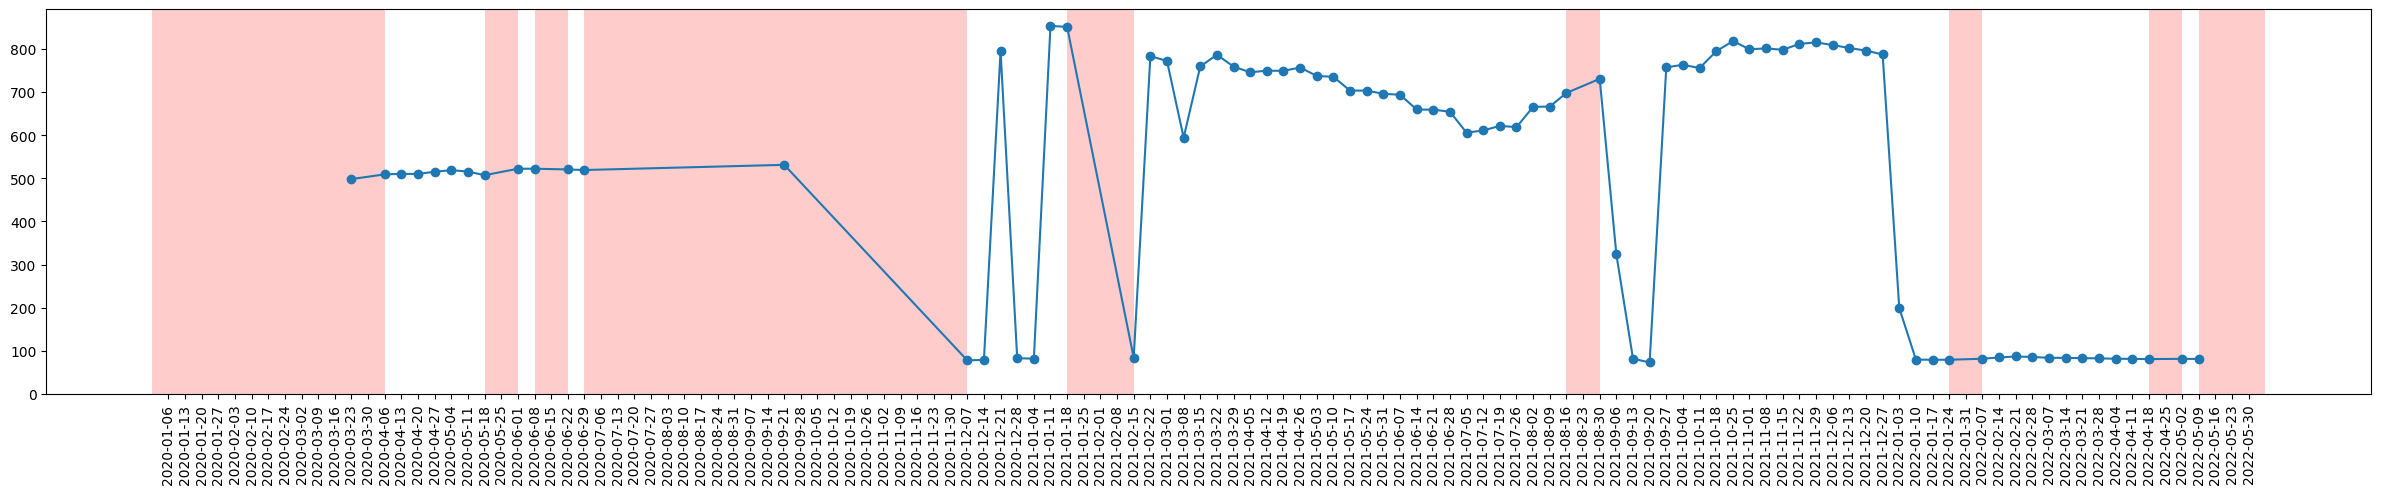

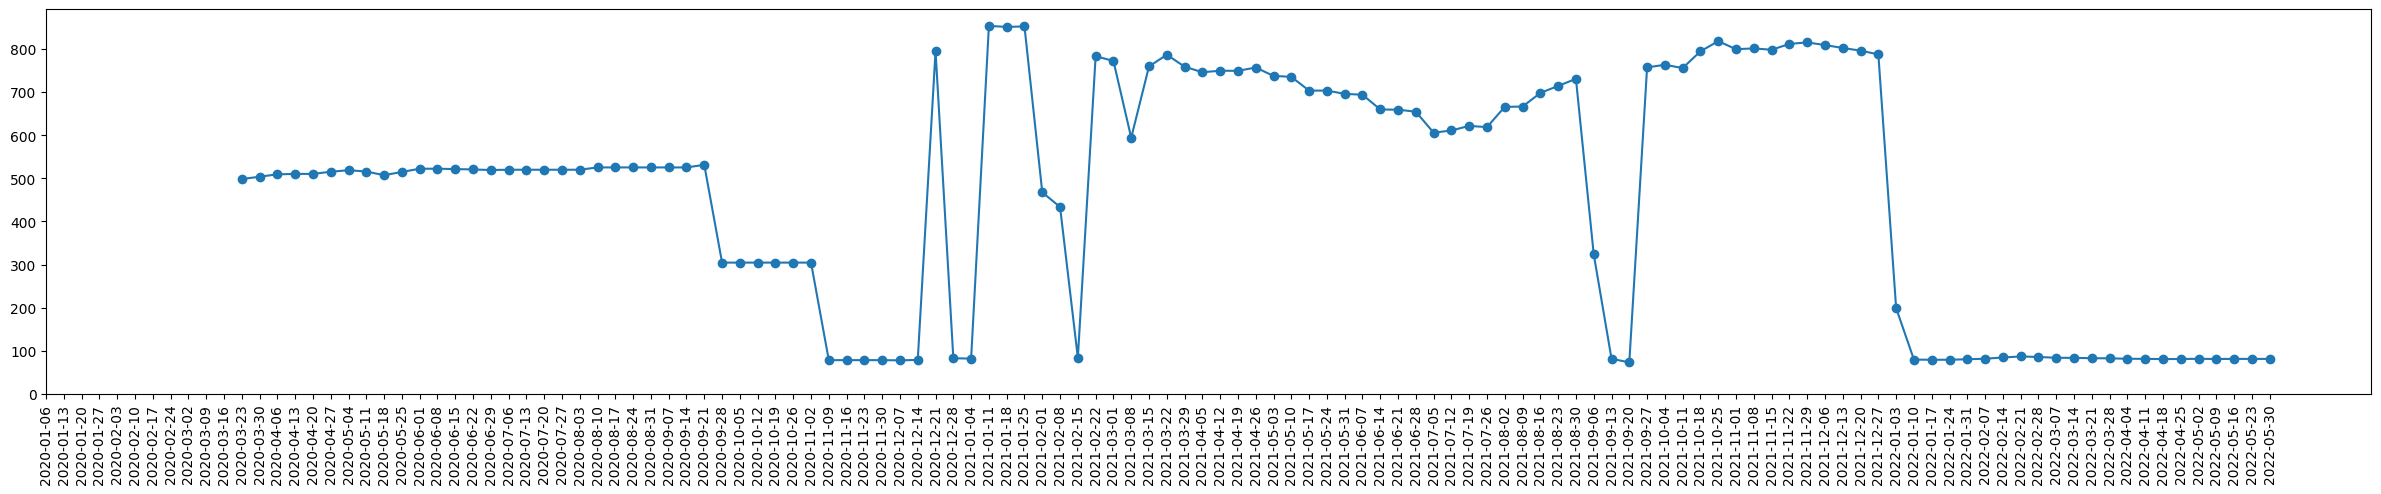

In [9]:
# step3: plot sample entry in 'df' with the largest variability

# entry = 58650041
entry = volatility_series.sort_values(ascending=False).index[0]
def plot_sample_with_ft(df_pivot, entry_id, imputed = False):
    if imputed is True:
        price_avg = 'price_avg_imputed'
    else:
        price_avg = 'price_avg'
    
    # Masking null_value
    sample_entry = df_pivot[df_pivot.index == entry_id].stack(dropna = False).reset_index().drop(['entry_id_'], axis = 1)
    x = sample_entry['date']
    y = sample_entry[price_avg].astype(np.double)
    ymask = np.isfinite(y)
    
    plt.figure(figsize = (30, 5))
    plt.plot(x[ymask], y[ymask], linestyle = '-', marker = 'o')
    plt.xticks(x, rotation = 90)
    plt.ylim(bottom = 0)
    
    # axvspan with red color - find index of start & end point of null
    sample_entry = sample_entry.set_index('date')
    is_nan = sample_entry[price_avg].isna()
    n_groups = is_nan.ne(is_nan.shift()).cumsum()
    
    if len(sample_entry[is_nan].groupby(n_groups).groups) > 1:
        gap_list = sample_entry[is_nan].groupby(n_groups).aggregate(
            lambda x: (
                x.index[0] + pd.DateOffset(days=-7),
                x.index[-1] + pd.DateOffset(days=+7)
            )
        )[price_avg].values
    
        for gap in gap_list:
            plt.axvspan(gap[0], gap[1], facecolor='r', alpha=0.2)
    
    plt.show()

plot_sample_with_ft(df_pivot = df_pivot, entry_id = entry)
plot_sample_with_ft(df_pivot = df_pivot, entry_id = entry, imputed = True)

# Outlier Detection

step1: define function to calculate the number of outliers & to plot the confidence bands

step2: do experiment to decide the parameter to use - size of window, sigma, etc.

step3: in last two months, count the total number of alarms by each entry

step4: suppose a price series is acquired in next time. count the total number of alarms by each entry

In [39]:
# Count the number of outliers, or plot the outliers
# Use confidence bands calculated by 'price_avg_imputed' to detect 'price_avg'
def outlier_func(df_pivot, entry_id, sigma=2, window = 4, display_plot = False, used_in_apply = False):
    
    # Plot price_avg & price_avg_imputed
    sample_entry = df_pivot[df_pivot.index == entry_id].stack(dropna = False).reset_index().drop(['entry_id_'], axis = 1)
    x = sample_entry['date']
    y = sample_entry['price_avg'].astype(np.double)
    y_imputed = sample_entry['price_avg_imputed'].astype(np.double)    
    
    # Trend_line & Confidence bands
    sample_entry['moving_avg'] = sample_entry['price_avg_imputed'].rolling(min_periods = 1, window = window).mean()
    sample_entry['moving_avg_shift'] = sample_entry['moving_avg'].shift(1)
    sample_entry['moving_avg_shift'] = sample_entry['moving_avg_shift'].fillna(sample_entry['moving_avg'])
        
    trend_line = sample_entry['moving_avg_shift']
    
    # Standardization
    Z_y = (y - y.mean()) / y.std()
    Z_y_imputed = (y_imputed - y.mean()) / y.std()
    Z_trend_line = (trend_line - trend_line.mean()) / trend_line.std()
    upper_band = Z_trend_line + sigma
    lower_band = Z_trend_line - sigma
    
    # Outlier detection
    x_idx_lst = []
    outlier_lst = []
    
    for i in range(len(Z_y)):
        if  Z_y[i] > upper_band[i] or Z_y[i] < lower_band[i]:
            x_idx_lst.append(i)
            outlier_lst.append(y[i])
    
    Z_y_outlier = np.where(Z_y.index.isin(x_idx_lst), Z_y, np.nan)
    
    if display_plot is True:
        plt.figure(figsize = (30, 5))
        plt.plot(x, Z_y, linestyle = '-', marker = 'o', color = '#5FBA09', markersize = 5)
        plt.plot(x, Z_y_imputed, linestyle = '--', marker = '^', color = '#5FBA09', alpha = 0.5, markersize = 5)
        plt.plot(x, Z_trend_line, color = '#ff9933')
        plt.plot(x, upper_band, '--', color='#ff0000')
        plt.plot(x, lower_band, '--', color='#ff0000')
        plt.plot(x, Z_y_outlier, 'o'
            , markersize = 12, markerfacecolor = 'None', markeredgecolor = '#0EB4F7', markeredgewidth = 2)
        plt.xticks(x, rotation = 90)
        plt.title(f'entry_id: {entry_id}, window: {window}, sigma: {sigma}')

        # axvspan with red color - find index of start & end point of null
        sample_entry = sample_entry.set_index('date')
        is_nan = sample_entry['price_avg'].isna()
        n_groups = is_nan.ne(is_nan.shift()).cumsum()

        if len(sample_entry[is_nan].groupby(n_groups).groups) > 1:
            gap_list = sample_entry[is_nan].groupby(n_groups).aggregate(
                lambda x: (
                    x.index[0] + pd.DateOffset(days=-7),
                    x.index[-1] + pd.DateOffset(days=+7)
                )
            )['price_avg'].values

            for gap in gap_list:
                plt.axvspan(gap[0], gap[1], facecolor='r', alpha=0.2)

        plt.show()
    
    if used_in_apply is True:
        return len(outlier_lst)
    else:
        return x_idx_lst, outlier_lst

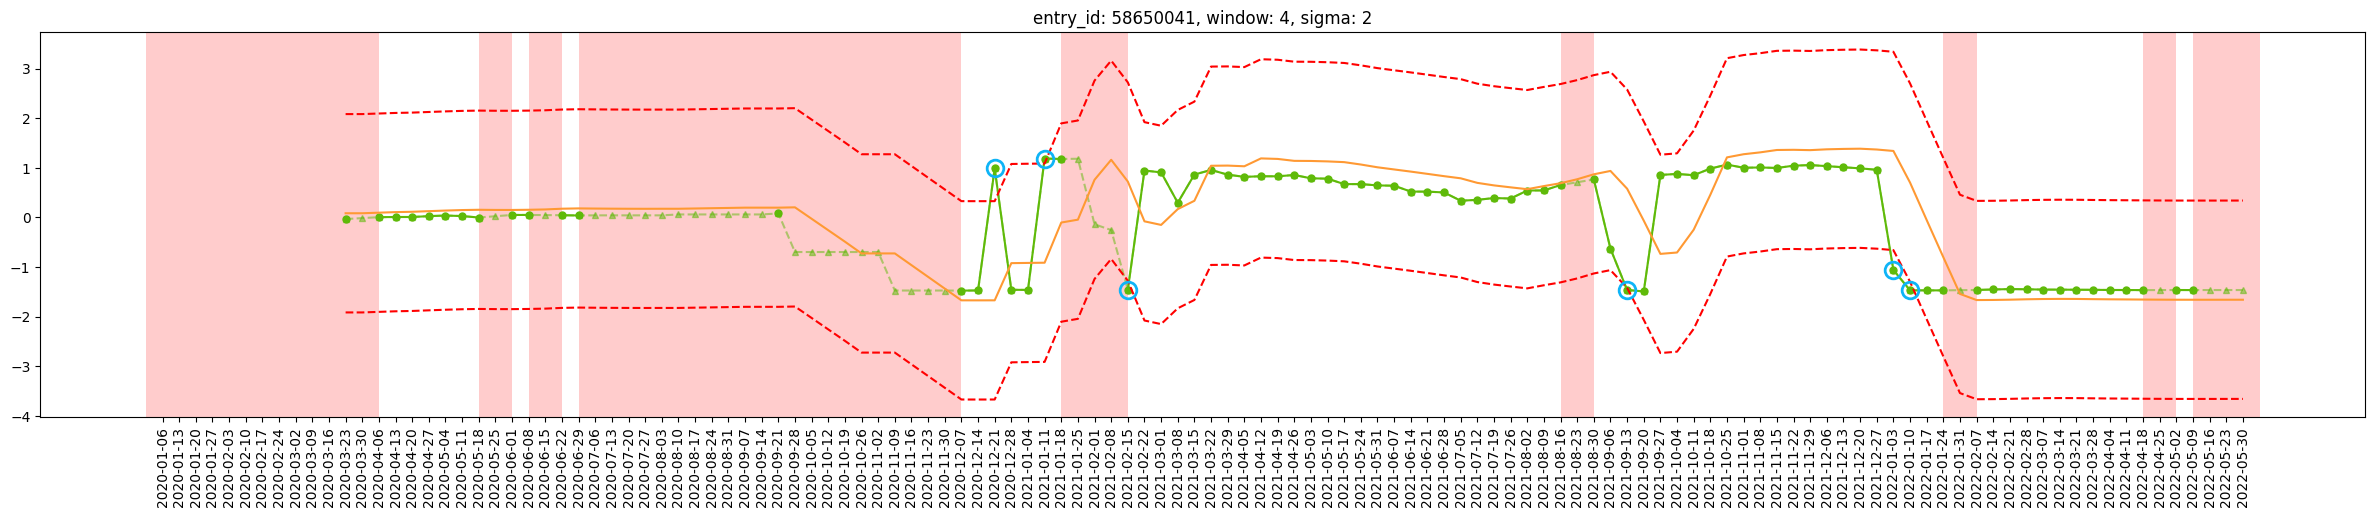

([50, 53, 58, 88, 104, 105], [795.0, 853.0, 84.0, 81.8, 199.0166666667, 79.75])

In [40]:
# Plot outlier detection
outlier_func(df_pivot = df_pivot, entry_id = entry, sigma = 2, window = 4, display_plot = True)

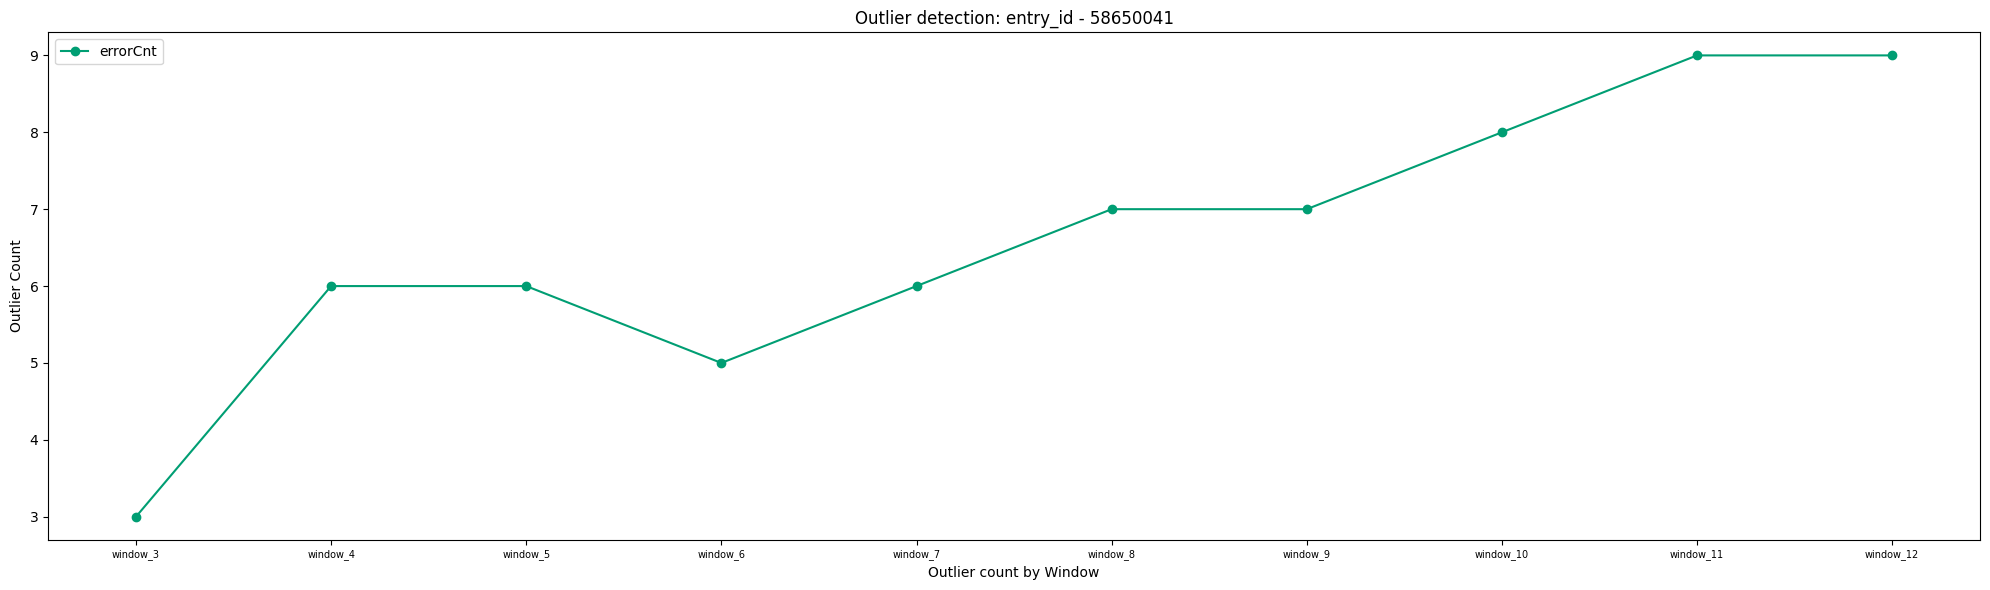

In [27]:
# Count the number of outliers, and plot the number of outliers
def errorCnt_by_window(df_pivot, entry_id, sigma = 2):
    # window from 3 to 12 - Count number of outliers
    for window in range(3, 13):
        df_pivot[f'outlier_cnt', f'window_{window}'] = df_pivot.apply(lambda row: outlier_func(df_pivot, entry_id = entry_id, sigma = sigma, window = window, used_in_apply = True), axis = 1)
    return df_pivot

def errorCnt_by_window_plot(df_pivot, entry_id):
    df_window = df_pivot['outlier_cnt'][df_pivot.index == entry_id].stack().to_frame(name = 'errorCnt')
    df_window.index.set_names(['entry_id_', 'window'], inplace = True)
    df_window = df_window.reset_index().set_index('window')
    
    plt.figure(figsize=(20, 6))
    plt.plot(df_window.index, df_window['errorCnt'], marker = 'o', linestyle = '-', color = '#009E73')
    plt.xlabel('Outlier count by Window')
    plt.xticks(rotation = 0, fontsize = 7)
    plt.ylabel('Outlier Count')
    plt.title(f'Outlier detection: entry_id - {entry_id}')
    plt.legend(['errorCnt'], loc = 'upper left')
    plt.tight_layout()

    plt.show()

df_pivot_outlierCnt = df_pivot[df_pivot.index == entry].copy()
errorCnt_by_window(df_pivot = df_pivot_outlierCnt, entry_id = entry, sigma = 2)
errorCnt_by_window_plot(df_pivot = df_pivot_outlierCnt, entry_id = entry)

  0%|                                                          | 0/10 [00:00<?, ?it/s]

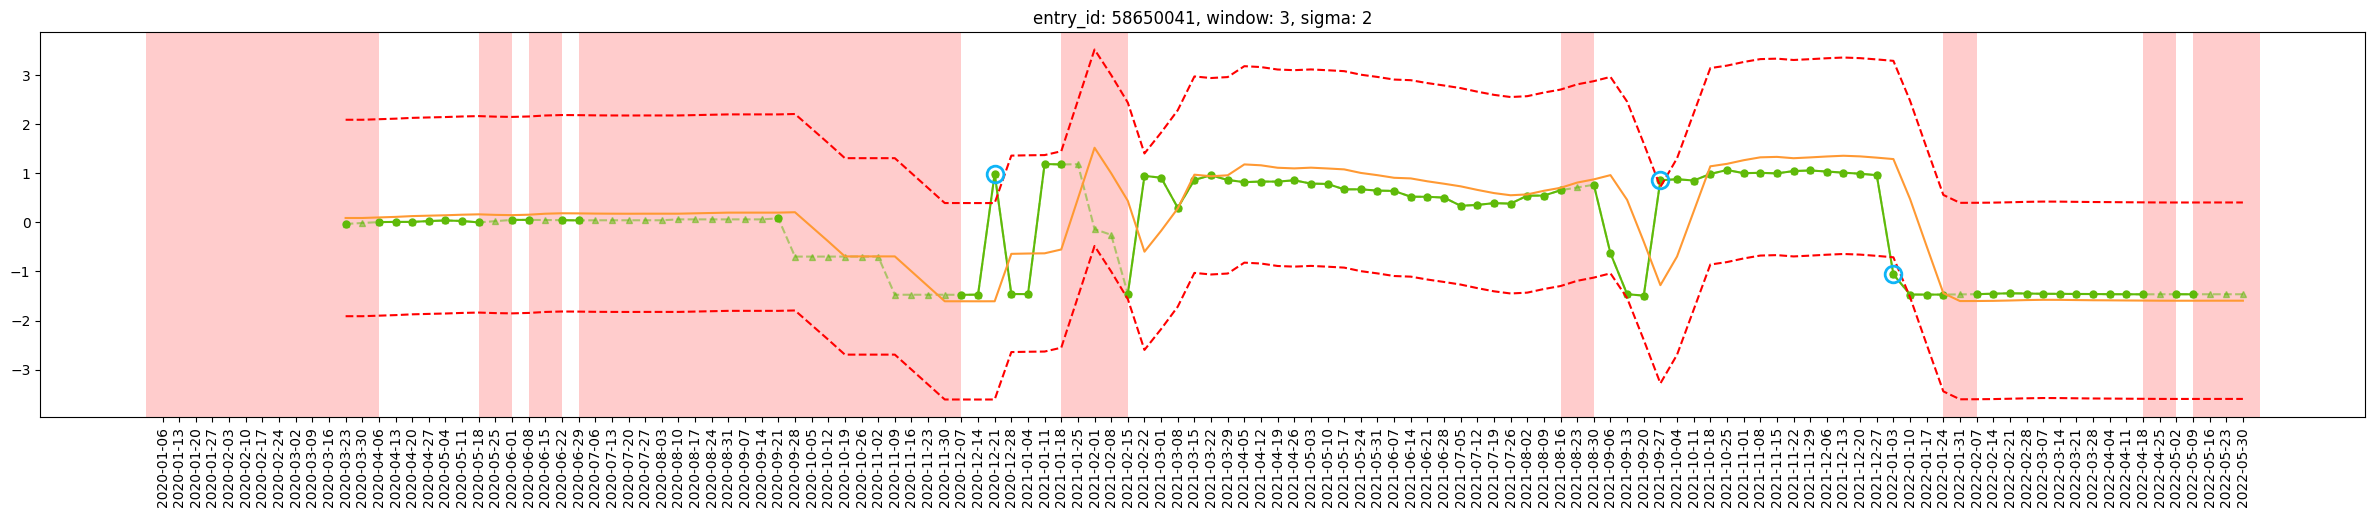

 10%|█████                                             | 1/10 [00:01<00:14,  1.61s/it]

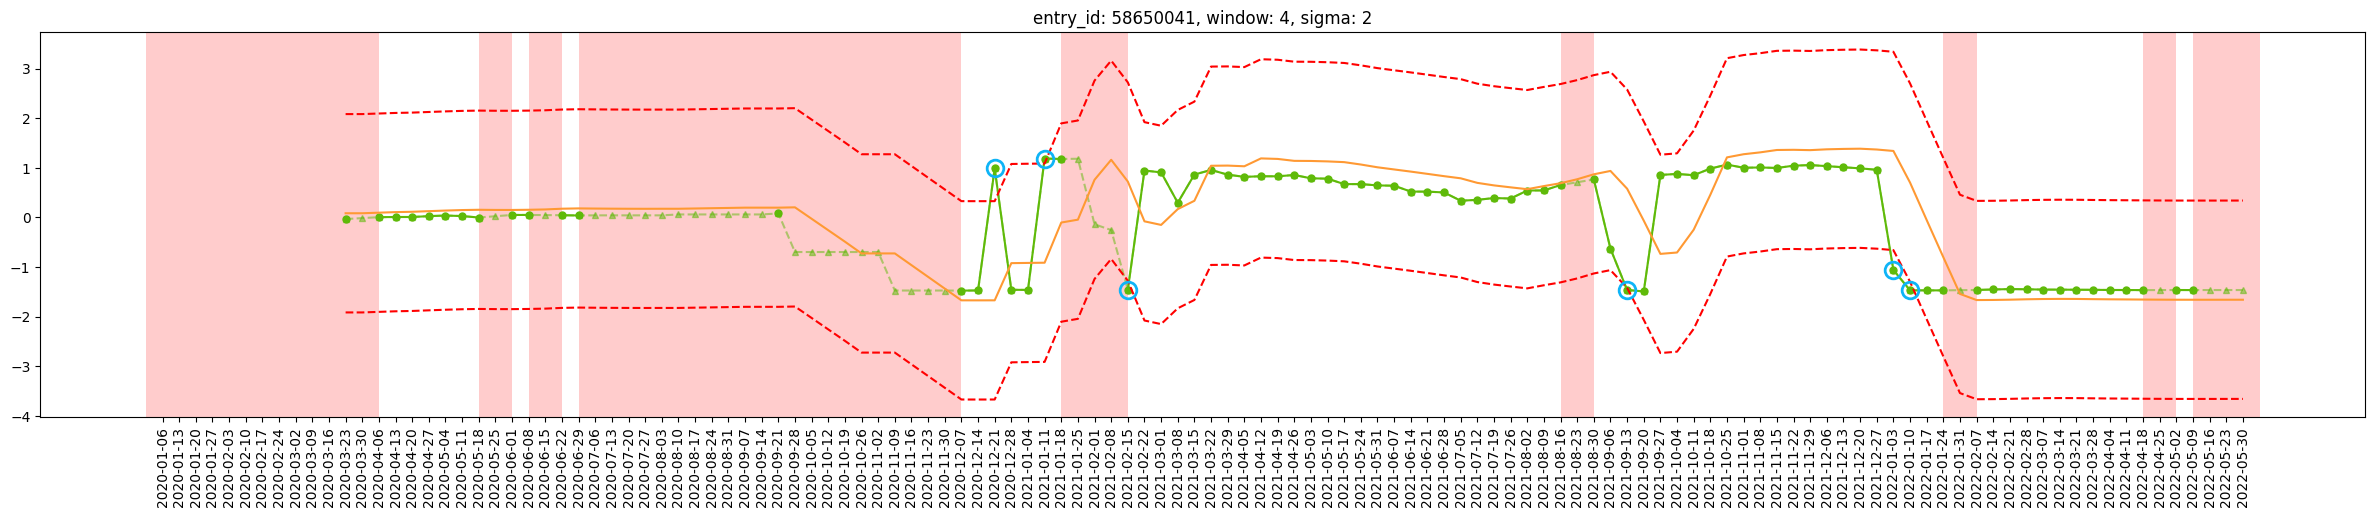

 20%|██████████                                        | 2/10 [00:03<00:12,  1.62s/it]

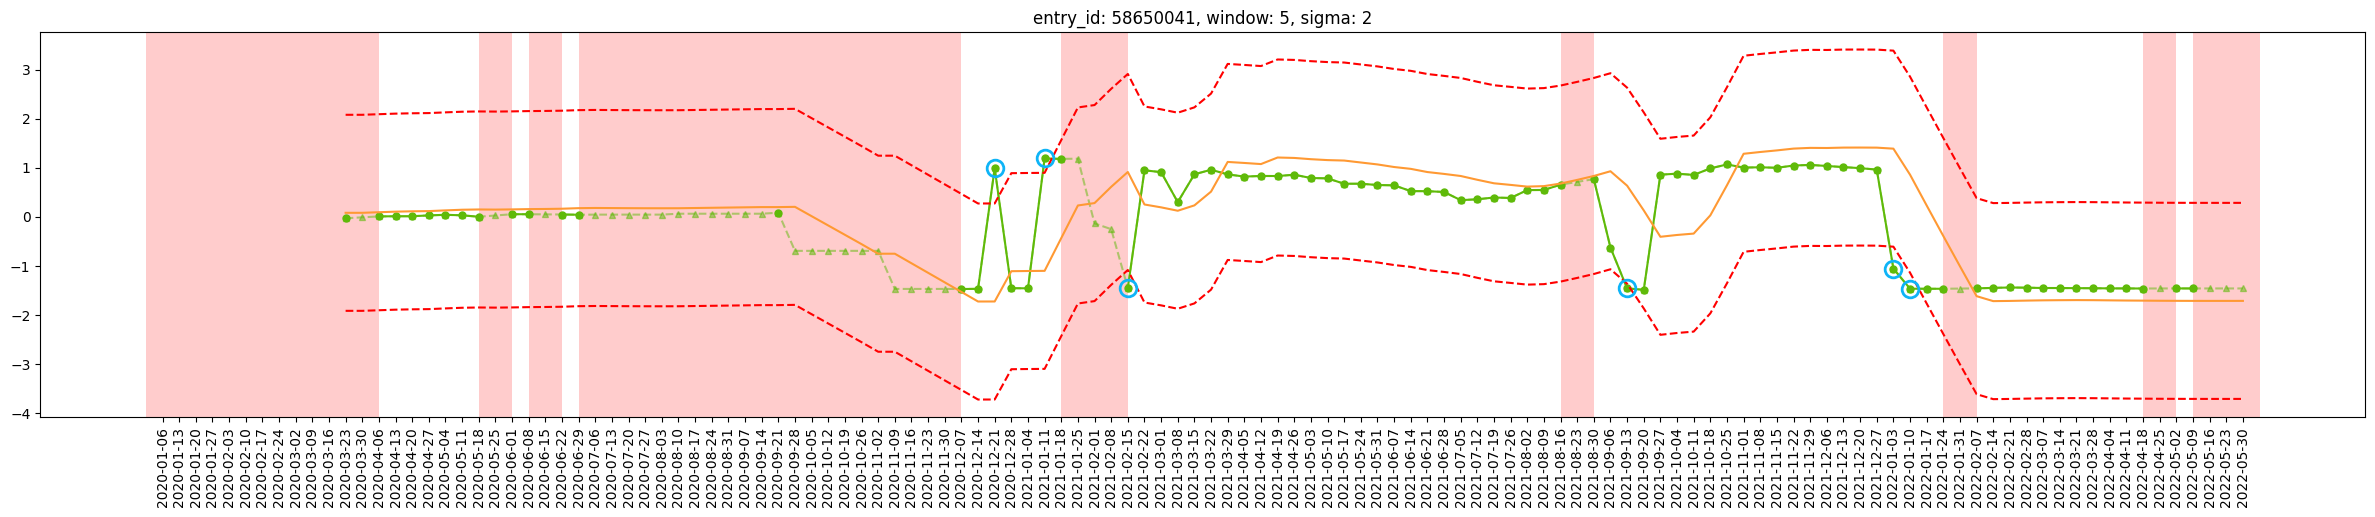

 30%|███████████████                                   | 3/10 [00:04<00:10,  1.51s/it]

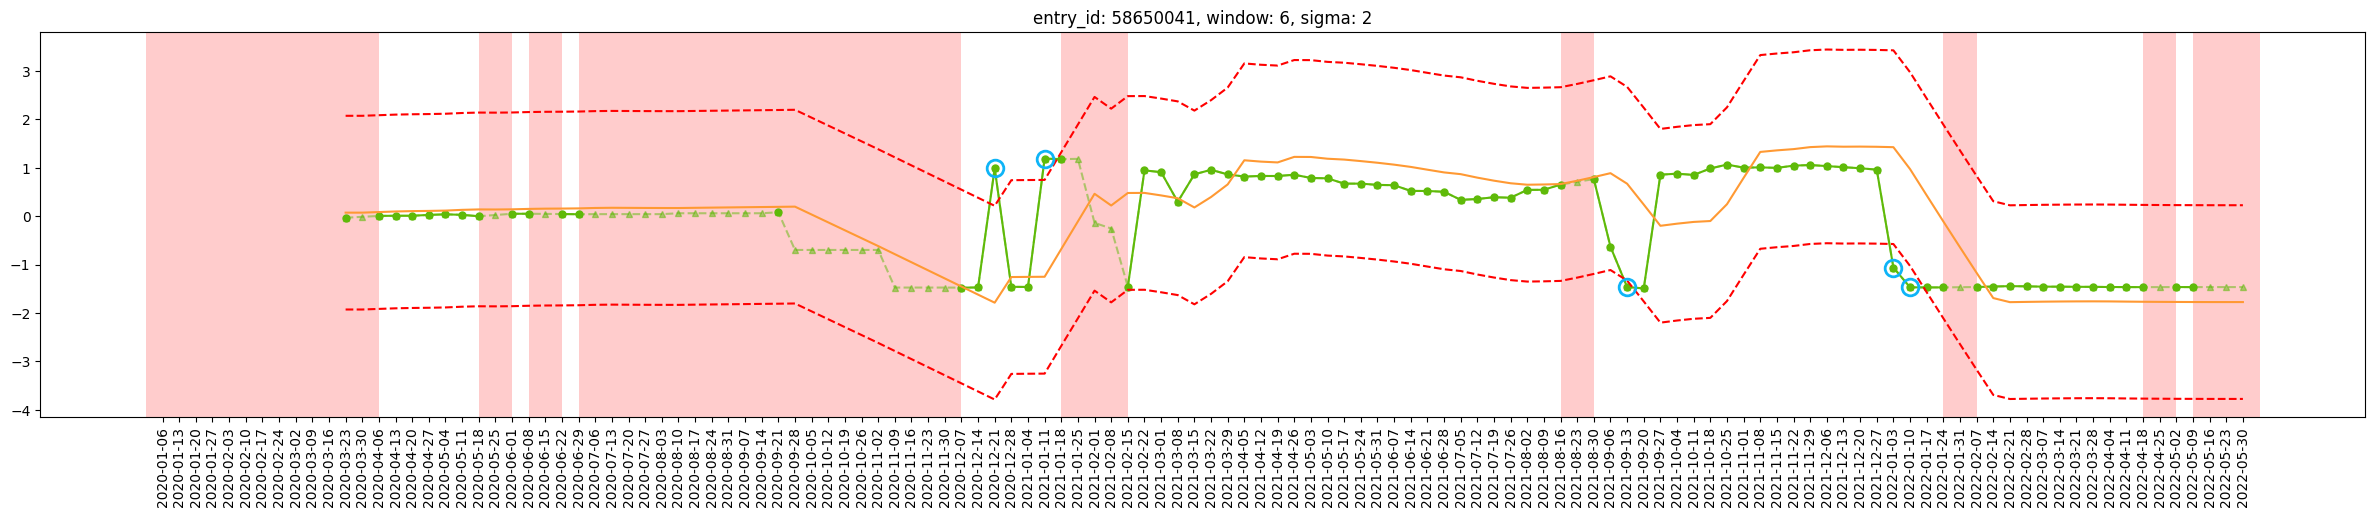

 40%|████████████████████                              | 4/10 [00:06<00:09,  1.50s/it]

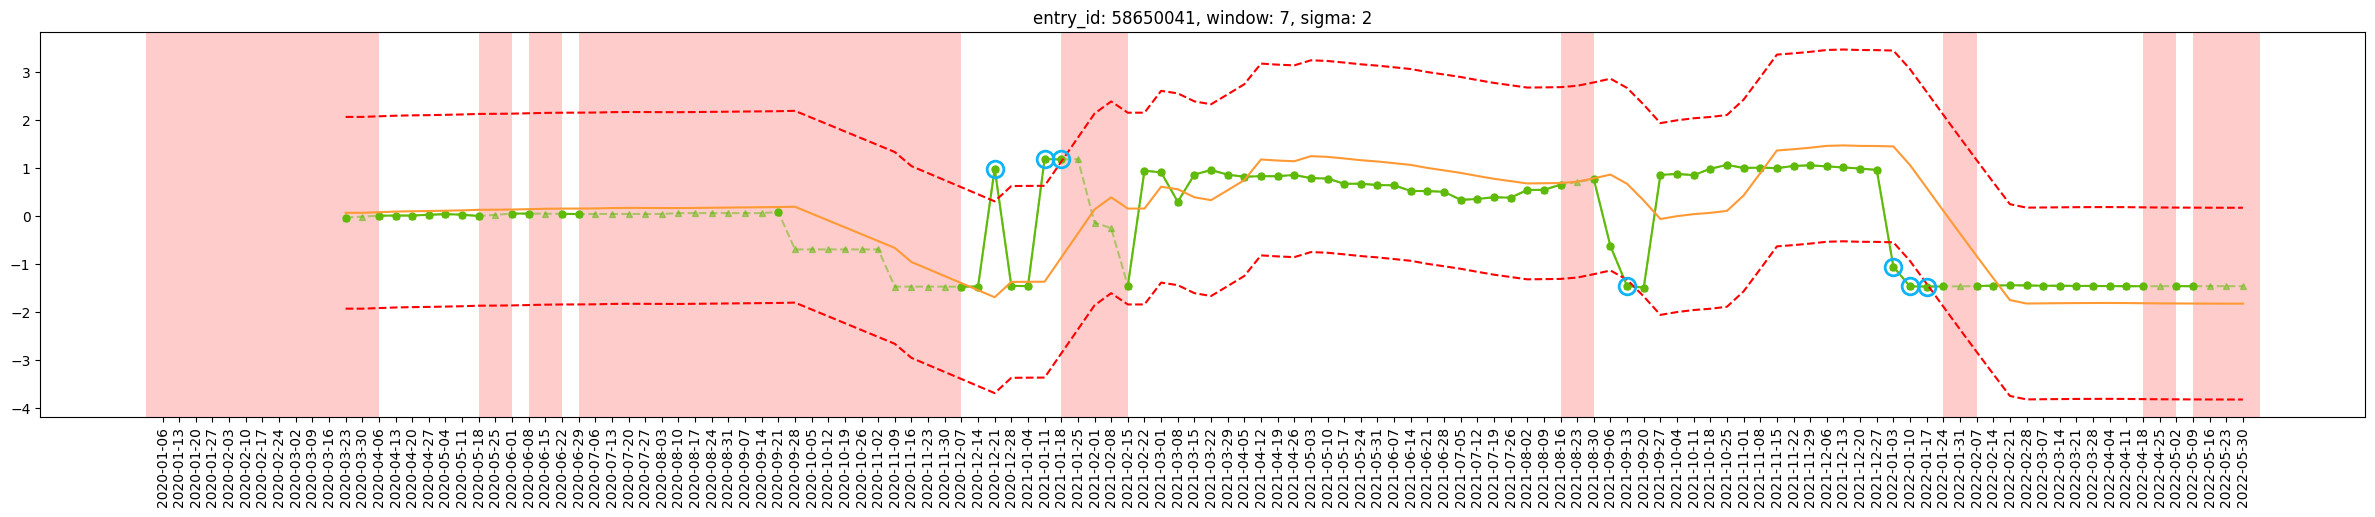

 50%|█████████████████████████                         | 5/10 [00:07<00:07,  1.52s/it]

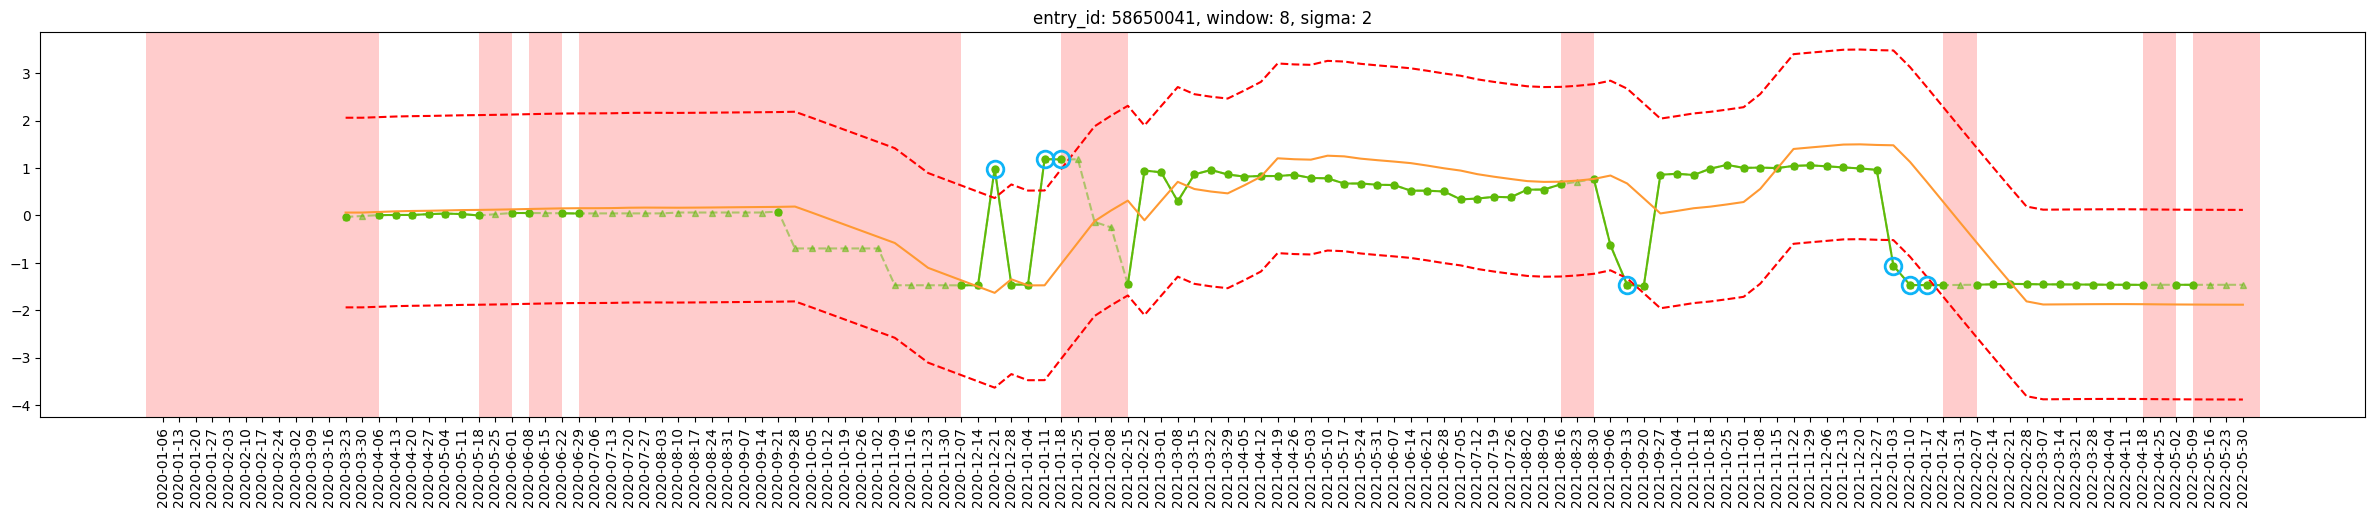

 60%|██████████████████████████████                    | 6/10 [00:09<00:06,  1.52s/it]

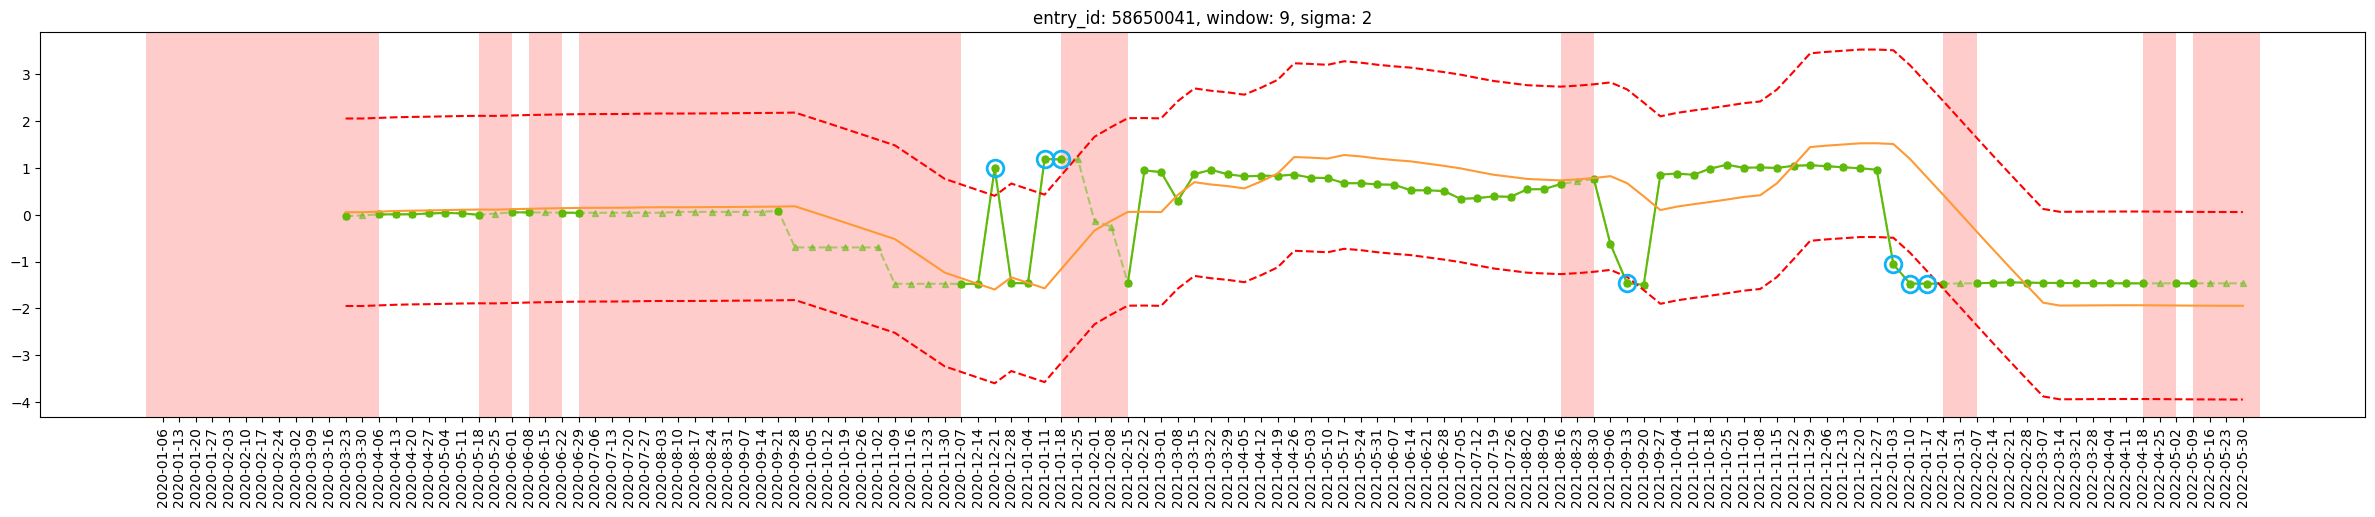

 70%|███████████████████████████████████               | 7/10 [00:10<00:04,  1.49s/it]

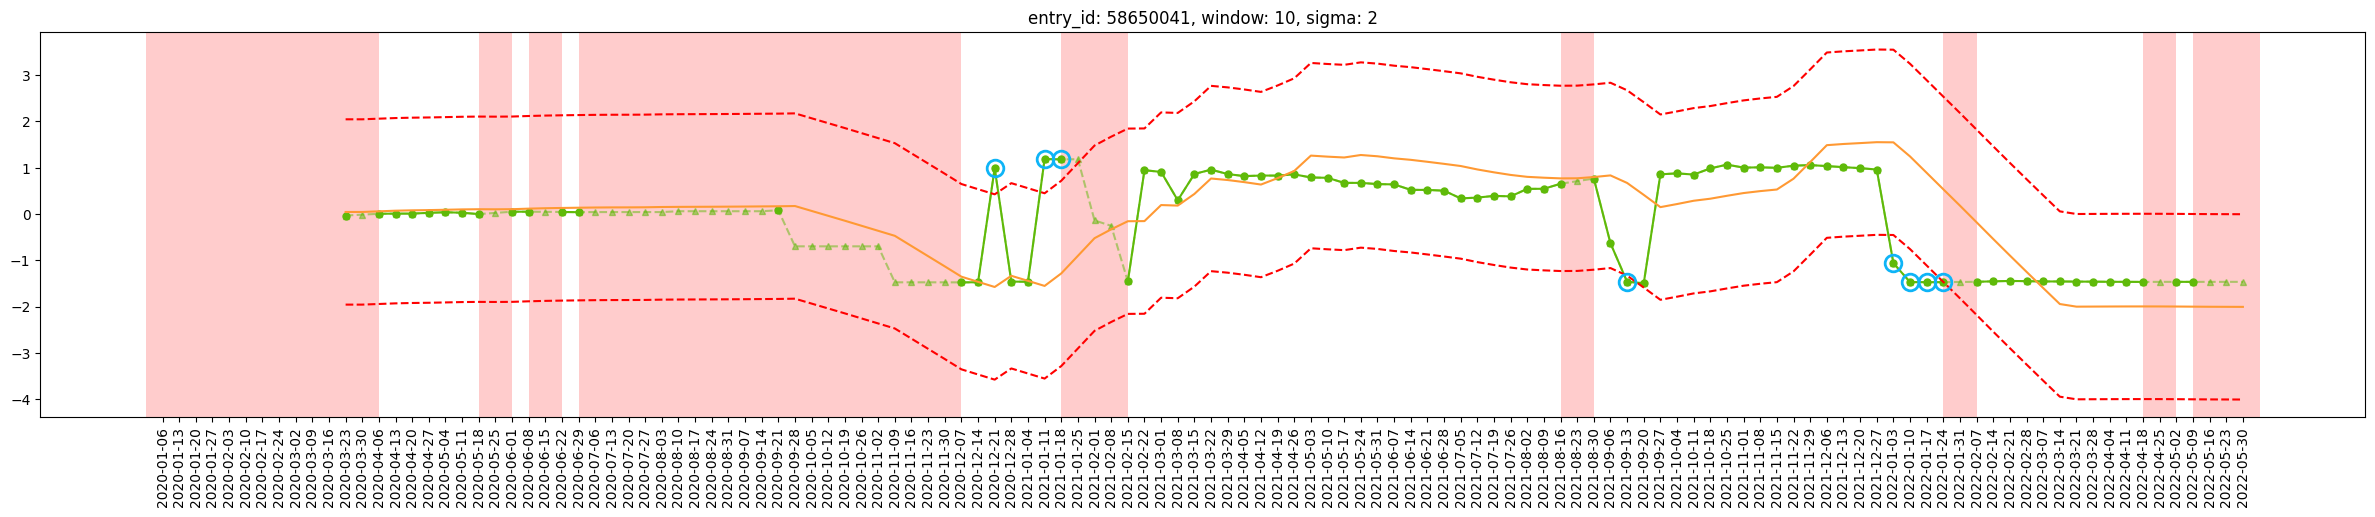

 80%|████████████████████████████████████████          | 8/10 [00:12<00:03,  1.59s/it]

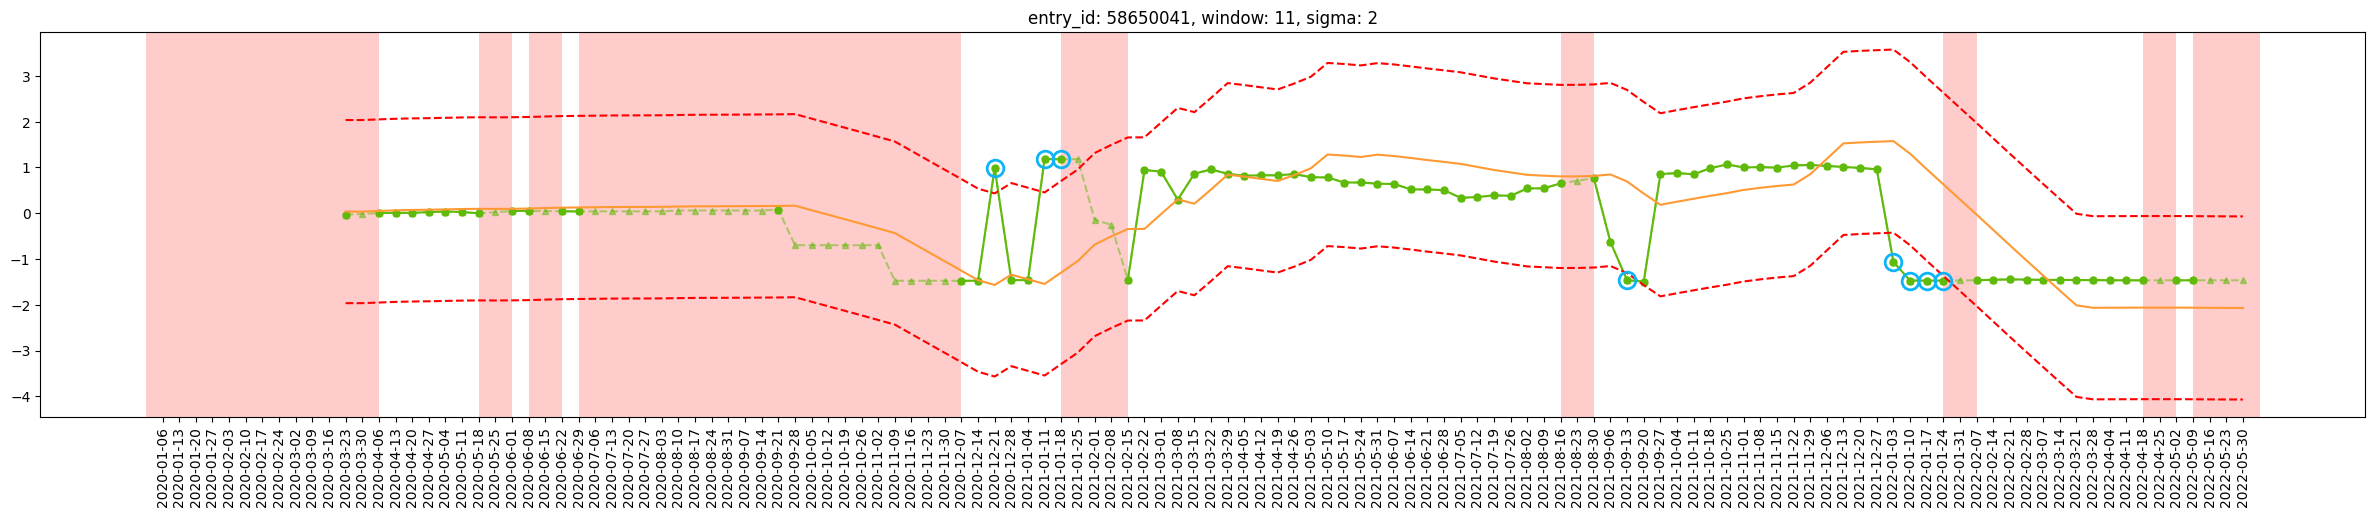

 90%|█████████████████████████████████████████████     | 9/10 [00:13<00:01,  1.52s/it]

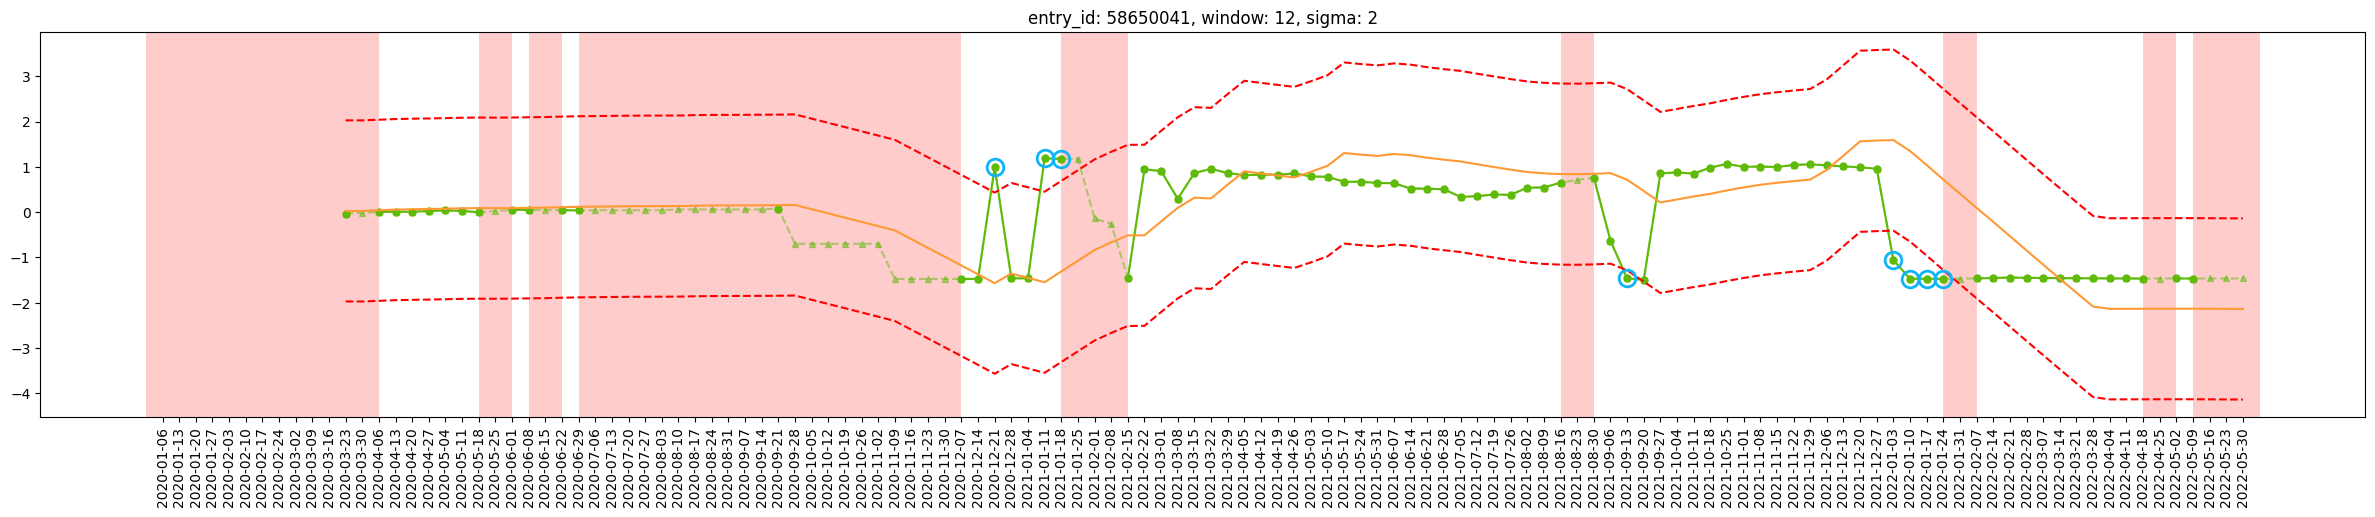

100%|█████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.50s/it]


In [13]:
# Plot outlier detection according to the size of window
for window in tqdm(range(3, 13)):
    outlier_func(df_pivot = df_pivot, entry_id = entry, sigma = 2, window = window, display_plot = True)

# Conclusion: Window = 4, sigma = 2
**Reason: Abnormal price would appear when:
1) External environment (e.g. bad weather, world war, shortage in supply)

2) Human mistake - mistakenly input the price data

Suppose that at a certain point (Tn-1), price changes with a huge rate, so the alarm occurs.
It could be the case because of the two reasons above.

Even though there could be some situations when price ups and downs frequently while drawing a huge amplitude, but those are rare. Generally, the changed price would maintain for a certain period of time (although there might be a slight change).

But, if we increase the window, then the detection bands would be too "flattend".
It will cause mainly two kind of problems as described below:
1) too flattened to detect the abnormalility.

2) detect again the next price ("Tn") and raise an alarm even it is plausible throughout the context. It is proved from the gragh above ("number of Outlier deteciton") that the number of alarms increase proportionally with size of the window.

# Compare new detection logic with as-is logic

In [14]:
# As-is Logic VS To-be Logic - Change rate > 200 %, then raise an alarm
def as_is_alarm(row, display_plot = False, plot_together = False):
    # As-is alarm 1
    outlier_dic = {'alarm1': [], 'alarm2': []}
    
    alarm1_x_idx_lst = []
    for i in range(1, len(row)):
        chg_rate = (row[i] - row[i-1]) / row[i-1]
        if chg_rate > 2:
            alarm1_x_idx_lst.append(i)
            outlier_dic['alarm1'].append(row[i])  

    # As-is alarm 2
    average = row.mean()
    threshold_min = average - 2 * np.std(row)
    threshold_max = average + 2 * np.std(row)
    if threshold_min < 0:
        threshold_min = 0
    
    alarm2_x_idx_lst = []
    for idx, point in enumerate(row, start = 0):
        if point < threshold_min or point > threshold_max:
            alarm2_x_idx_lst.append(idx)
            outlier_dic['alarm2'].append(point)
    
    if display_plot is True:
        plt.figure(figsize = (20, 5))
        
        plt.plot(row, marker= 'o')
        plt.plot([0, len(row)], [average, average], '-')
        plt.plot([0, len(row)], [threshold_min, threshold_min], '--', color='#ff0000')
        plt.plot([0, len(row)], [threshold_max, threshold_max], '--', color='#ff0000')
        plt.plot(alarm1_x_idx_lst, outlier_dic['alarm1'], 'o'
                 , markersize = 12, markerfacecolor = 'None', markeredgecolor = 'red', markeredgewidth = 2 )
        plt.plot(alarm2_x_idx_lst, outlier_dic['alarm2'], 'o'
                 , markersize = 12, markerfacecolor = 'None', markeredgecolor = 'green', markeredgewidth = 2 )       
        
        if plot_together is True:
            plt.plot(new_x_idx_lst, new_outlier_lst, 'o'
                     , markersize = 20, markerfacecolor = 'None', markeredgecolor = 'black', markeredgewidth = 2 )
            
        plt.xlabel('Time (weeks)')
        plt.ylabel('Price')
        plt.legend(['Price', 'Average', 'Lower bound', 'Upper bound', 'As-is Alarm1', 'As-is Alarm2', 'New Alarm'], loc = 'lower right'
                  , borderpad = 0.5, labelspacing = 1)    
        plt.tight_layout()
        
        plt.show()
    
    alarm1_set = set(outlier_dic['alarm1'])
    alarm2_set = set(outlier_dic['alarm2'])
    unioned_set = alarm1_set.union(alarm2_set)
    
    return alarm1_set, alarm2_set, unioned_set

In [19]:
new_x_idx_lst, new_outlier_lst = outlier_func(df_pivot = df_pivot, entry_id = entry, sigma = 2, window = 4, display_plot = False)

# As-is Logic VS To-be Logic - Change rate > 200 %, then raise an alarm
def as_is_alarm_(df_pivot, entry_id, display_plot = False, plot_together = False):
    entry_df = df_pivot[df_pivot.index == entry_id].stack(dropna = False).reset_index().drop(['entry_id_'], axis = 1)
    x = entry_df['date']
    price = entry_df['price_avg']
    
    # As-is alarm 1
    outlier_dic = {'alarm1': [], 'alarm2': []}
    
    alarm1_x_idx_lst = []
    for i in range(1, len(entry_df)):
        chg_rate = (price[i] - price[i-1]) / price[i-1]
        if chg_rate > 2:
            alarm1_x_idx_lst.append(i)
            outlier_dic['alarm1'].append(price[i]) 
    
    price_alarm1 = np.where(price.index.isin(alarm1_x_idx_lst), price, np.nan)

    # As-is alarm 2
    average = price.mean()
    threshold_min = average - 2 * price.std()
    threshold_max = average + 2 * price.std()
    if threshold_min < 0:
        threshold_min = 0
    
    alarm2_x_idx_lst = []
    for idx, point in enumerate(price, start = 0):
        if point < threshold_min or point > threshold_max:
            alarm2_x_idx_lst.append(idx)
            outlier_dic['alarm2'].append(point)
    
    price_alarm2 = np.where(price.index.isin(alarm2_x_idx_lst), price, np.nan)
    
    # To-be alarm
    new_price_alarm = np.where(price.index.isin(new_x_idx_lst), price, np.nan)
    
    if display_plot is True:
        plt.figure(figsize = (30, 5))
        
        plt.plot(x, price, marker= 'o')
        plt.plot([x.iat[0], x.iat[len(x)-1]], [average, average], '-')
        plt.plot([x.iat[0], x.iat[len(x)-1]], [threshold_min, threshold_min], '--', color='#ff0000')
        plt.plot([x.iat[0], x.iat[len(x)-1]], [threshold_max, threshold_max], '--', color='#ff0000')
        plt.plot(x, price_alarm1, 'o'
                 , markersize = 12, markerfacecolor = 'None', markeredgecolor = 'red', markeredgewidth = 2 )
        plt.plot(x, price_alarm2, 'o'
                 , markersize = 12, markerfacecolor = 'None', markeredgecolor = 'green', markeredgewidth = 2 )       
        
        if plot_together is True:
            plt.plot(x, new_price_alarm, 'o'
                     , markersize = 20, markerfacecolor = 'None', markeredgecolor = '#0EB4F7', markeredgewidth = 2 )
        plt.xticks(x, rotation = 90)
        plt.xlabel('Time (weeks)')
        plt.ylabel('Price')
        plt.legend(['Price', 'Average', 'Lower bound', 'Upper bound', 'As-is Alarm1', 'As-is Alarm2', 'New Alarm'], loc = 'lower right'
                  , borderpad = 0.5, labelspacing = 1)    
        plt.tight_layout()
        
        plt.show()
    
    alarm1_set = set(outlier_dic['alarm1'])
    alarm2_set = set(outlier_dic['alarm2'])
    unioned_set = alarm1_set.union(alarm2_set)
    
    return alarm1_set, alarm2_set, unioned_set


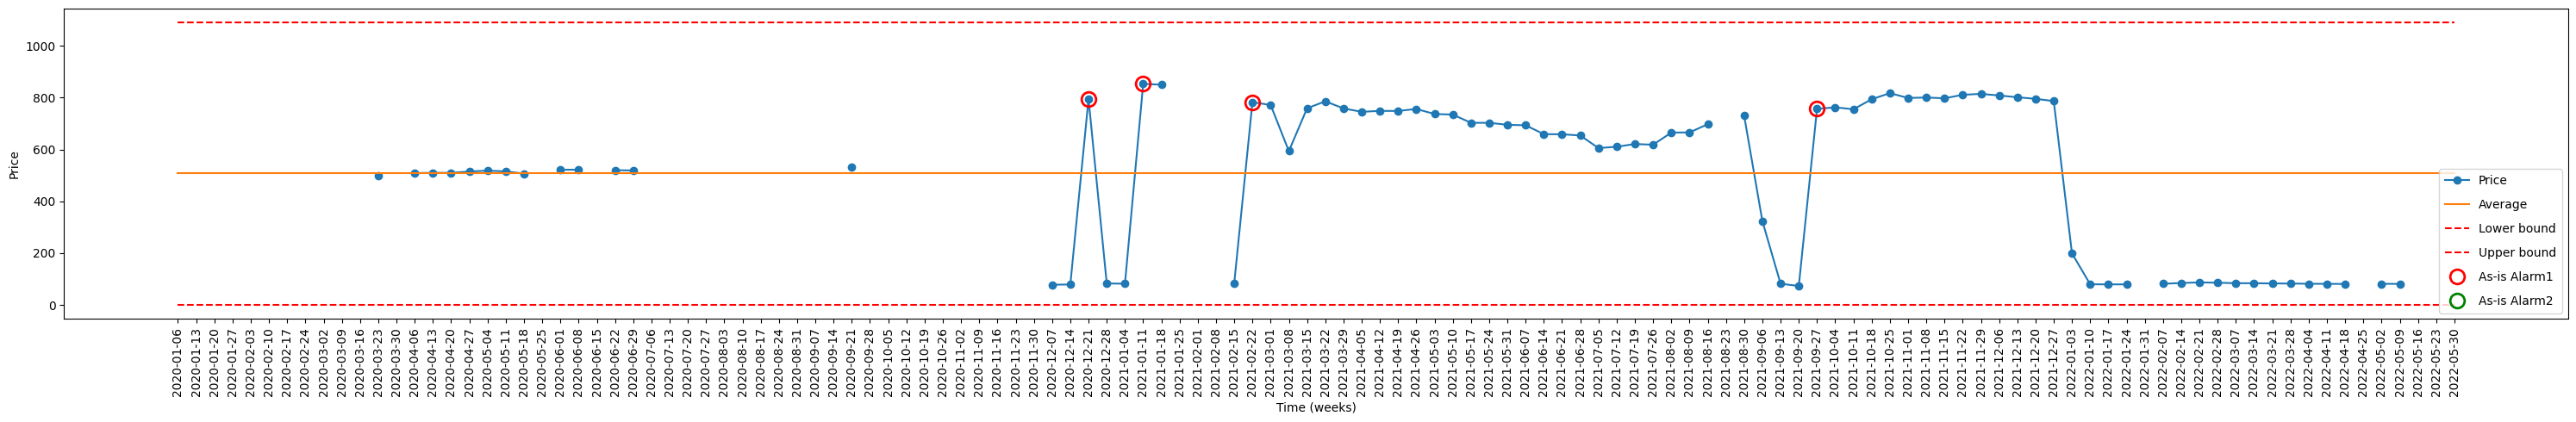

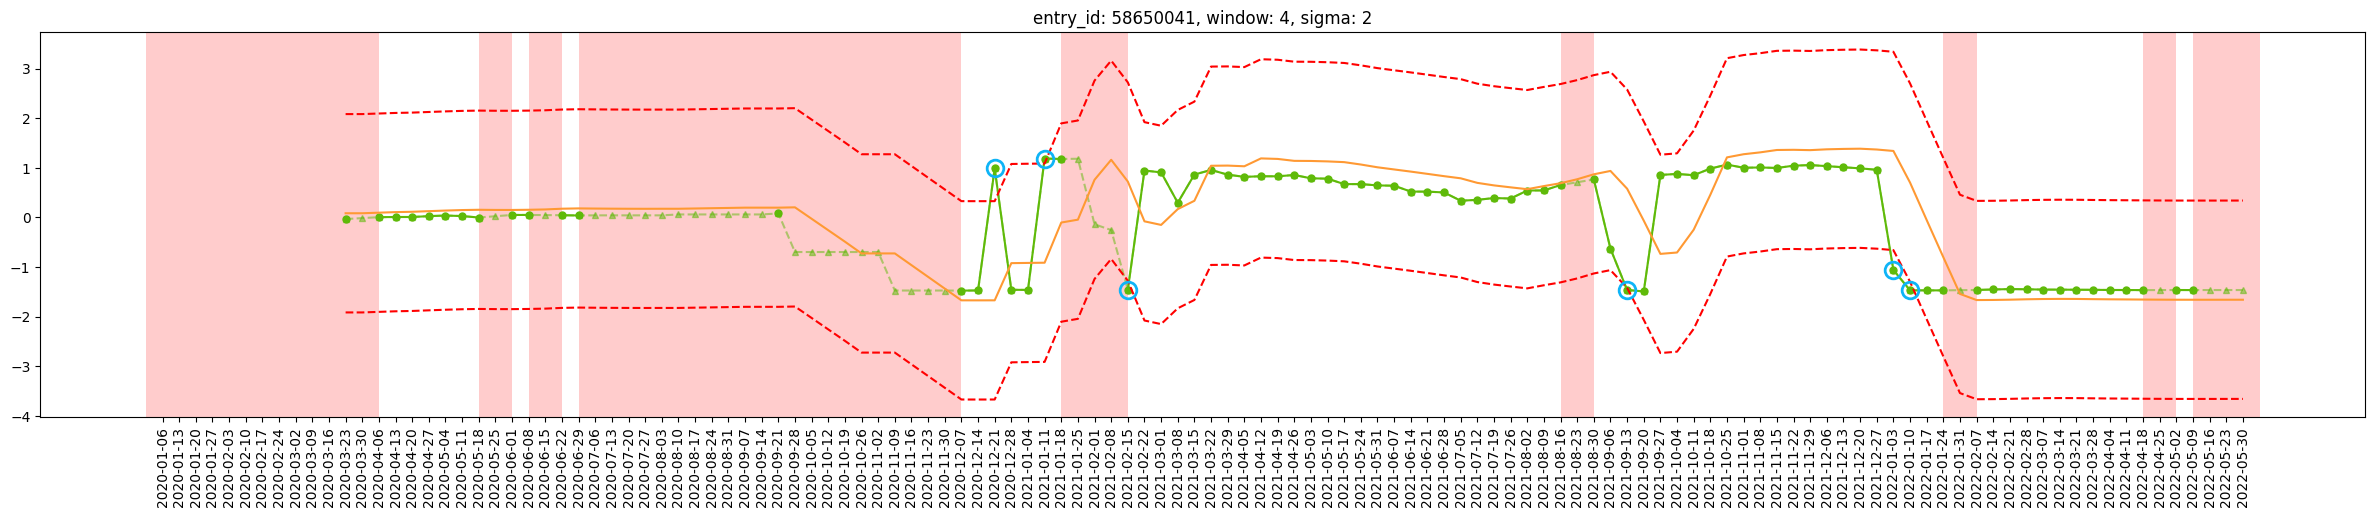

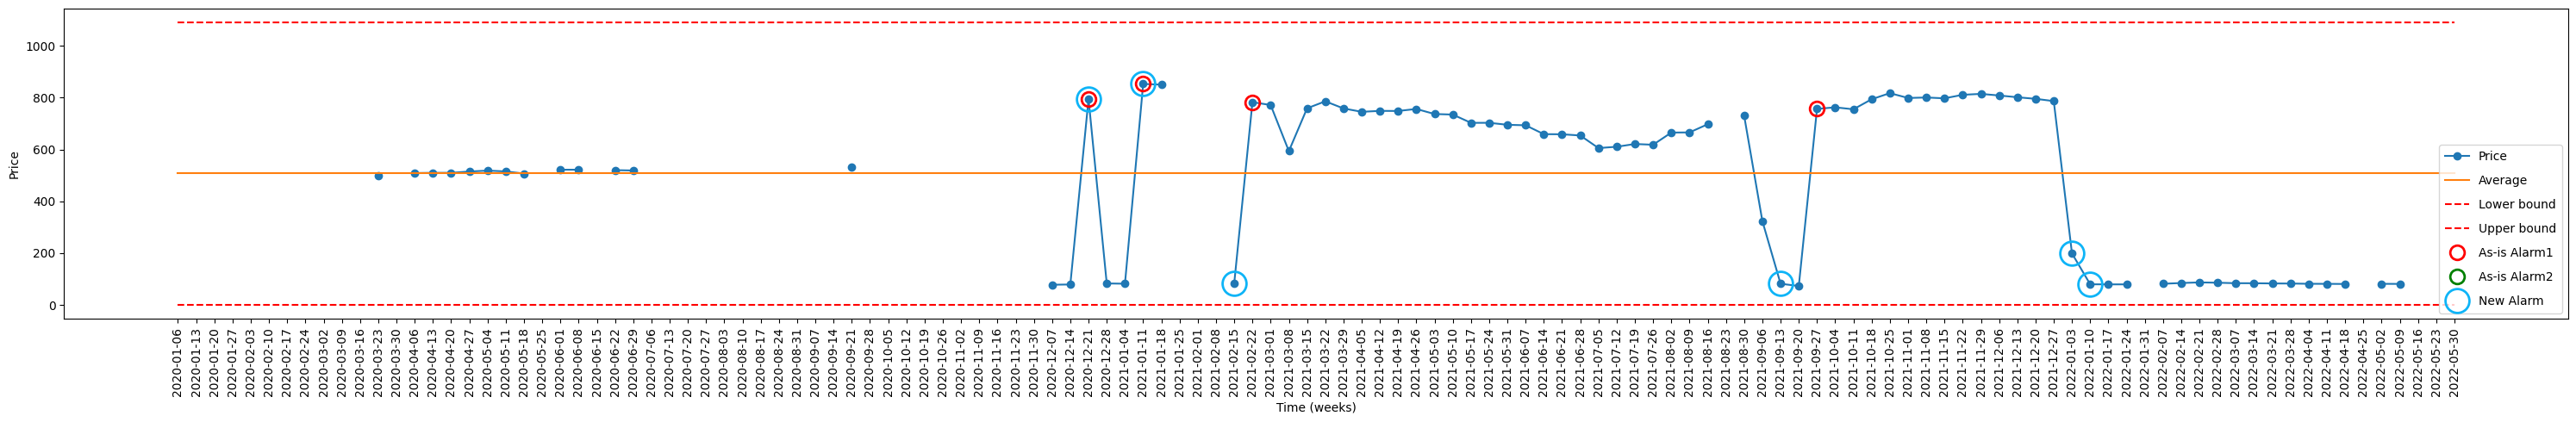

As-is alarm 1 (Alarm 1): [756.8, 782.7333333333, 795.0, 853.0]
As-is alarm 2 (Alarm 2): []
As-is alarm 1, 2 union: [756.8, 782.7333333333, 795.0, 853.0]

To-be alarm 1, 2 : [79.75, 81.8, 84.0, 199.0166666667, 795.0, 853.0]


In [20]:
# As-is Logic
alarm1_set, alarm2_set, unioned_set = as_is_alarm_(df_pivot, entry_id = entry, display_plot = True)
# To-be Logic
outlier_func(df_pivot = df_pivot, entry_id = entry, sigma = 2, window = 4, display_plot = True)
# Together
as_is_alarm_(df_pivot, entry_id = entry, display_plot = True, plot_together = True)
print(f'As-is alarm 1 (Alarm 1): {sorted(alarm1_set)}')
print(f'As-is alarm 2 (Alarm 2): {sorted(alarm2_set)}')
print(f'As-is alarm 1, 2 union: {sorted(unioned_set)}')
print()
print(f'To-be alarm 1, 2 : {sorted(new_outlier_lst)}')

# Experiments

In [120]:
df_ = df[['date', 'entry_id_', 'price_avg', 'price_avg_imputed']].copy()
df_.index.dtype

dtype('int64')

In [121]:
def Raize_alarm(price_avg, price_avg_imputed):
#     print(price_avg) # series
#     print(price_avg_imputed) # series
    y = price_avg.astype(np.double)
    y_imputed = price_avg_imputed.astype(np.double)
    
    # Trend_line & Confidence bands
    moving_avg = y_imputed.rolling(min_periods = 1, window = window).mean()
    moving_avg_shift = moving_avg.shift(1)
    moving_avg_shift = moving_avg_shift.fillna(moving_avg)
    trend_line = moving_avg_shift
    
    # Standardization
    Z_y = (y - y.mean()) / y.std()
    Z_y_imputed = (y_imputed - y.mean()) / y.std()
    Z_trend_line = (trend_line - trend_line.mean()) / trend_line.std()
    upper_band = Z_trend_line + 2
    lower_band = Z_trend_line - 2

    df_y = Z_y.to_frame(name = 'Standardized_price')
    df_y['Alarm'] = np.where((Z_y > upper_band) | (Z_y < lower_band), 1, 0)
    
    Alarm_series = df_y['Alarm']
    return Alarm_series
    
Alarm_series = df_.groupby('entry_id_').apply(lambda row : Raize_alarm(row.price_avg, row.price_avg_imputed))
Alarm_df = Alarm_series.to_frame().reset_index(drop = True)
df_ = pd.concat([df_, Alarm_df], axis = 1)

In [122]:
df_[(df_['date'] > pd.Timestamp('2022-01-01')) & (df_['Alarm'] == 1)]

,date,entry_id_,price_avg,price_avg_imputed,Alarm
219,2022-01-03,58650041,199.016667,199.016667,1
220,2022-01-10,58650041,79.750000,79.750000,1
221,2022-01-17,58650041,79.400000,79.400000,1
222,2022-01-24,58650041,79.420000,79.420000,1
348,2022-01-24,58655008,499.800000,499.800000,1
352,2022-02-21,58655008,223.500004,223.500004,1


# Simple Imputer (Strategy = 'Median')
https://velog.io/@jee-9/%EA%B2%B0%EC%B8%A1%EC%B9%98Nulls-%EC%B2%98%EB%A6%AC%EC%97%90-%EB%8C%80%ED%95%B4%EC%84%9C-Imputation-Single-MICE


# Iterative Imputer
models each feature with missing values as a function of other features, and uses that estimate for imputation. It does so in an iterated round-robin fashion: at each step, a feature columns is designated as output y and the other feature columns are treated as inputs X. A regressor is fit on (X, y) for known y. Then the regressor is used to predict the missing values of y. This is done for each feature in an iterative fashion, and then is repeated for max_iter imputation rounds. The results of the final imputation round are returned.


# KNN Imputer
using K-Nearest Neighbors to impute the missing values

Find the best k : https://wikidocs.net/125444

Principle of KNNImputer : https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/

Type of imputation : https://dining-developer.tistory.com/19

In [17]:
# # Simple Inputer
# from sklearn.impute import SimpleImputer
# Raw_simp_median = Raw.copy()
# imputer = SimpleImputer(strategy = 'median')
# Raw_simp_median['price_avg'] = imputer.fit_transform(Raw_simp_median) # np.ndarray
# Raw_simp_median = Raw_simp_median.unstack()

# # Compare Full time period Plot
# plot_sample_with_ft(df_pivot = df_pivot, entry_id = entry)
# plot_sample_with_ft(Raw_simp_median, 58650041)

# # Compare moving average
# outlier_func(df_pivot['price_avg'].values[~np.isnan(df_pivot['price_avg'].values)], sigma = 2, window = 4, display_plot=True)
# outlier_func(Raw_simp_median['price_avg'].values[0], sigma = 2, window = 4, display_plot=True)

# # IterativeImputer
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# Raw_iter = Raw.copy()
# imputer = IterativeImputer(max_iter = 10, random_state = 0)
# Raw_iter['price_avg'] = imputer.fit_transform(Raw_iter)
# Raw_iter = Raw_iter.unstack()

# # # Compare Full time period Plot
# plot_sample_with_ft(df_pivot = df_pivot, entry_id = entry)
# plot_sample_with_ft(Raw_iter, 58650041)

# # Compare moving average
# outlier_func(df_pivot['price_avg'].values[~np.isnan(df_pivot['price_avg'].values)], sigma = 2, window = 4, display_plot=True)
# outlier_func(Raw_simp_iter['price_avg'].values[0], sigma = 2, window = 4, display_plot=True)